In [1]:
import torch
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import os
import pandas
from dataset import getPerformancesList
%matplotlib inline

In [24]:
SNAPSHOTS_DIR = "/home/pasinducw/Documents/research/university-work-scs-4224/comparing-rnn-params/model/model-snapshots/exp15"
SONGS_DIR = "/home/pasinducw/Downloads/Research-Datasets/covers80/covers80_cqt/"

In [25]:
excluded_transforms = [
        "_PITCH_SHIFT_0", "_PITCH_SHIFT_1", "_PITCH_SHIFT_2", "_PITCH_SHIFT_3", "_PITCH_SHIFT_4",
        "_TIME_STRETCH_0", "_TIME_STRETCH_1", "_TIME_STRETCH_2", "_TIME_STRETCH_3", "_TIME_STRETCH_4",
    ]

# Object array of shape {song: string, name: string, path: string} containing the details of performances
PERFORMANCES = getPerformancesList(root_dir = SONGS_DIR, excluded_transforms = excluded_transforms)

In [26]:
# Array containing the songs
SONGS = []
for performance in PERFORMANCES:
    SONGS.append(performance['song'])
SONGS = np.unique(SONGS)

In [27]:
# Add model training metrics to the performance
# Resulting object -> { song: string, name: string, path: string, training_loss: list, training_accuracy: list}

for (index, performance) in enumerate(PERFORMANCES):
    snapshot_location = os.path.join(
        SNAPSHOTS_DIR,
        '{}-{}'.format(index, performance['name']),
        'snapshot-400.pytorch'
    )
    snapshot = torch.load(snapshot_location)
    print(snapshot)
    break
    performance['train_loss'] = snapshot['history']['train_loss'] 
    performance['train_accuracy'] = snapshot['history']['train_accuracy'] 
    

{'epoch': 400, 'model_state_dict': OrderedDict([('rnn.weight_ih_l0', tensor([[-0.0427,  0.5581, -0.0234,  ..., -0.1917,  0.2254,  0.2888],
        [-0.1453, -0.0720, -0.2328,  ..., -0.1977, -0.2718, -0.2059],
        [-0.2861,  0.4499,  0.3489,  ..., -0.0756, -0.0231,  0.1107],
        ...,
        [ 0.1472,  0.0536, -0.0496,  ..., -0.4928,  0.1156, -0.3555],
        [-0.0571, -0.2646,  0.1279,  ..., -0.4045,  0.0151, -0.1116],
        [-0.2870,  0.0922,  0.1313,  ...,  0.2655, -0.0080, -0.0260]])), ('rnn.weight_hh_l0', tensor([[ 0.0255,  0.0729,  0.0821,  ...,  0.1099, -0.0138, -0.1099],
        [-0.0826,  0.1126, -0.0689,  ..., -0.0301,  0.0707,  0.0029],
        [-0.0059, -0.0616, -0.1623,  ..., -0.1111,  0.0336,  0.0323],
        ...,
        [ 0.1468, -0.0700,  0.1692,  ...,  0.2024, -0.0560,  0.0570],
        [ 0.0433, -0.2463,  0.2383,  ..., -0.2392,  0.0333, -0.1008],
        [ 0.0675, -0.0660,  0.1188,  ..., -0.0506,  0.0943,  0.0490]])), ('rnn.bias_ih_l0', tensor([ 9.5771e-02

In [20]:
validation_losses = []
for performance in PERFORMANCES:
    validation_losses.append(performance['training_loss'][399])

print(np.average(validation_losses))

KeyError: 'training_loss'

In [19]:
validation_accuracies = []
for performance in PERFORMANCES:
    validation_accuracies.append(performance['validation_accuracy'][199])

print(np.max(validation_accuracies))

32.03125


### Computing cosine similarity

In [6]:
cos_similarity = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

for (base_index, base_performance) in enumerate(PERFORMANCES):
    similarity_values = []
    for (test_index, test_performance) in enumerate(PERFORMANCES):
        base_params = base_performance['parameters'].unsqueeze(0)
        test_params = test_performance['parameters'].unsqueeze(0)
        similarity = cos_similarity(base_params, test_params).squeeze().detach().numpy()
        similarity_values.append(similarity)
    base_performance['similarity_values'] = np.array(similarity_values)

In [7]:
for (index, performance) in enumerate(PERFORMANCES):
    ranks = np.argsort(-performance['similarity_values'])
    matched_songs = []
    for matched_performance_index in ranks:
        matched_song_index = np.where(SONGS == PERFORMANCES[matched_performance_index]['song'])
        matched_songs.append(matched_song_index[0][0])

    performance['matched_songs'] = matched_songs

In [ ]:
# PERFORMANCES[35]['song']
# PERFORMANCES[1]['matched_songs']

In [60]:
def getUnique(items):
    unique_items = []
    for item in items:
        already_there = False
        for existing_item in unique_items:
            if item == existing_item:
                already_there = True
        if not already_there:
            unique_items.append(item)
    return unique_items

def calculateNextOccurrence(performance_index, drop_duplicates=False, match_key='matched_songs'):
    relavant_song_index = PERFORMANCES[performance_index][match_key][0]
    fetched_song_indices = np.where(PERFORMANCES[performance_index][match_key][1:] == relavant_song_index)
    if drop_duplicates:
        fetched_song_indices = np.where(getUnique(PERFORMANCES[performance_index][match_key][1:]) == relavant_song_index)
    return fetched_song_indices[0][0]

In [21]:
occurrences = []
for (index,performance) in enumerate(PERFORMANCES):
    occurrence = calculateNextOccurrence(index)
    occurrences.append(occurrence)
np.average(occurrences)

133.827743902439

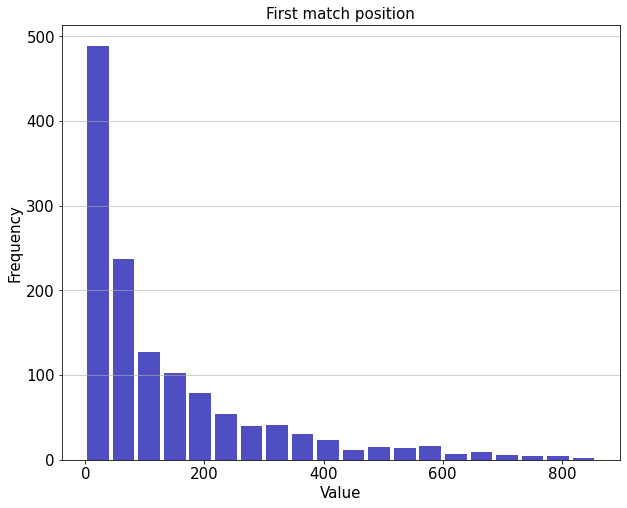

In [22]:
plt.figure(figsize=[10,8])
n, bins, patches = plt.hist(x=occurrences, bins=20, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('First match position',fontsize=15)
plt.show()

In [23]:
occurrences = []
for (index,performance) in enumerate(PERFORMANCES):
    occurrence = calculateNextOccurrence(index, True)
    occurrences.append(occurrence)
np.average(occurrences)

35.63795731707317

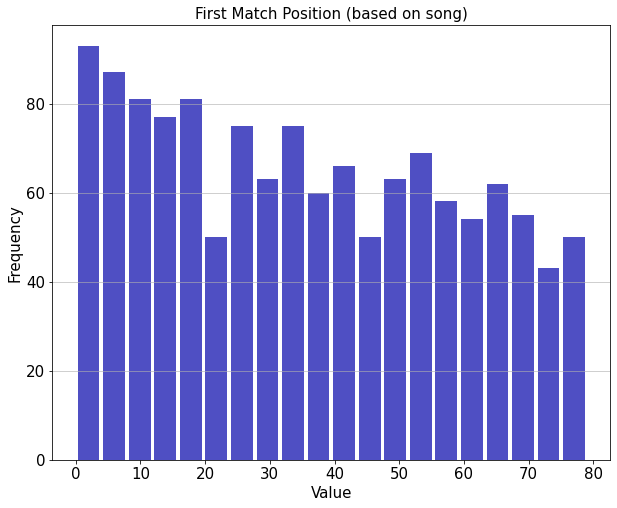

In [24]:
plt.figure(figsize=[10,8])
n, bins, patches = plt.hist(x=occurrences, bins=20, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('First Match Position (based on song)',fontsize=15)
plt.show()

# Based purely on cosine similarity

In [52]:
length_upper = 42 * 119 + 336
length_lower = 0
CQT_TOP_DROP_BINS: int = 36
print(length_upper)

5334


In [55]:
for performance in PERFORMANCES:
    cqt = np.load(performance['path'])
    frames = cqt
    frames = frames.transpose()
    frames = frames[length_lower:length_upper, :]
    frames = frames[:, :-CQT_TOP_DROP_BINS:]
#     maxIndices = np.argmax(frames, axis=1)
    
#     filteredFrames = np.zeros(frames.shape, dtype=bool)
#     for (step, index) in enumerate(maxIndices):
#         filteredFrames[step, index] = 1.0

#     filteredFrames = filteredFrames[:, :-CQT_TOP_DROP_BINS]
#     print(filteredFrames.shape)
    performance['raw'] = frames.flatten()

In [57]:
cos_similarity = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

for (base_index, base_performance) in enumerate(PERFORMANCES):
    similarity_values = []
    for (test_index, test_performance) in enumerate(PERFORMANCES):
        base_params = torch.from_numpy(base_performance['raw']).type(torch.float32).unsqueeze(0)
        test_params = torch.from_numpy(test_performance['raw']).type(torch.float32).unsqueeze(0)
        similarity = cos_similarity(base_params, test_params).squeeze().detach().numpy()
        similarity_values.append(similarity)
    base_performance['raw_similarity_values'] = np.array(similarity_values)

In [58]:
for (index, performance) in enumerate(PERFORMANCES):
    ranks = np.argsort(-performance['raw_similarity_values'])
    matched_songs = []
    for matched_performance_index in ranks:
        matched_song_index = np.where(SONGS == PERFORMANCES[matched_performance_index]['song'])
        matched_songs.append(matched_song_index[0][0])

    performance['raw_matched_songs'] = matched_songs

In [61]:
occurrences = []
for (index,performance) in enumerate(PERFORMANCES):
    occurrence = calculateNextOccurrence(index, match_key='raw_matched_songs')
    occurrences.append(occurrence)
np.average(occurrences)

43.77439024390244

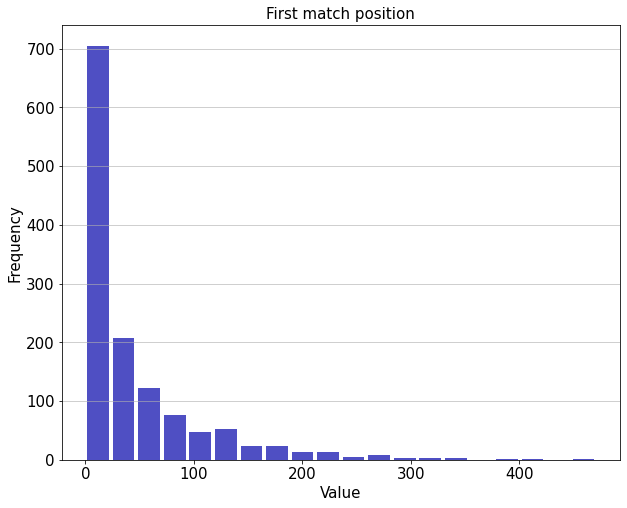

In [62]:
plt.figure(figsize=[10,8])
n, bins, patches = plt.hist(x=occurrences, bins=20, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('First match position',fontsize=15)
plt.show()

In [65]:
occurrences = []
for (index,performance) in enumerate(PERFORMANCES):
    occurrence = calculateNextOccurrence(index, True, match_key='raw_matched_songs')
    occurrences.append(occurrence)
np.average(occurrences)

23.95655487804878

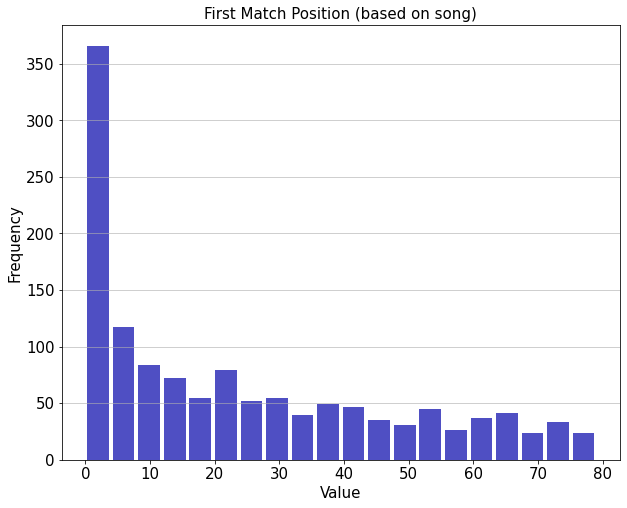

In [66]:
plt.figure(figsize=[10,8])
n, bins, patches = plt.hist(x=occurrences, bins=20, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('First Match Position (based on song)',fontsize=15)
plt.show()